# SMS Spam Detection

In [168]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    roc_curve, RocCurveDisplay)
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from scipy.stats import randint
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
 

# NLP library.
import nltk 
# Download some NLTK required packages. Uncomment if not downloaded.
# nltk.download('punkt') 
# nltk.download('punkt_tab')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

### Importing the data-set:

In [2]:
data = pd.read_csv('../data/spam.csv', encoding='latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
print("Shape of data:")
print(data.shape)
print("\nNull Values of data:")
print(data.isnull().sum()) 
print("\nDuplicated Values of data:")
print(data.duplicated().sum())

Shape of data:
(5572, 5)

Null Values of data:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Duplicated Values of data:
403


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data Cleaning:

In [5]:
def preprocess(data):
    columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
    
    # Check if any of these columns exist
    if not any(col in data.columns for col in columns):
        print("Data is already preprocessed.")
        return data
    
    # Otherwise preprocess
    data.drop(columns=columns, inplace=True, errors='ignore')
    data.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
    data.drop_duplicates(keep='first', inplace=True)
    data['target'] = LabelEncoder().fit_transform(data['target'])

    print("Preprocessing completed.")
    return data

In [6]:
data = preprocess(data)

Preprocessing completed.


In [7]:
data.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Checking for missing values and duplicates after preprocessing data
print("Missing:")
print(data.isnull().sum())
print("\nDuplicates")
print(data.duplicated().sum())
print("\nShape of data:")
print(data.shape)

Missing:
target    0
text      0
dtype: int64

Duplicates
0

Shape of data:
(5169, 2)


### Feature Engineering:

In [9]:
def add_features(data):
    # Feature names
    features = ['num_characters', 'num_words', 'num_sentences']
    
    # Check if features already exist
    if all(feature in data.columns for feature in features):
        print("Features already added.")
        return data
    
    # Otherwise, create the features
    data['num_characters'] = data['text'].apply(len)
    data['num_words'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x)))
    data['num_sentences'] = data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

    print("Feature engineering completed.")
    return data

In [10]:
data = add_features(data)

Feature engineering completed.


In [11]:
data.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


### EDA:

In [12]:
# Checking the values in the target column.
data['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

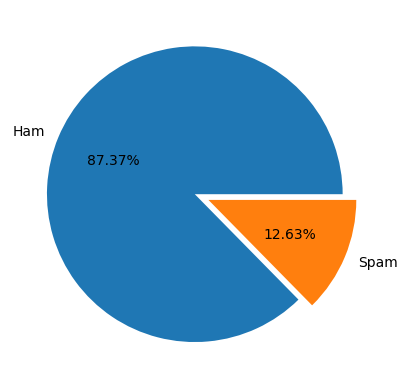

In [12]:
# Plotting a pie chart to see the Target Column
plt.pie(data['target'].value_counts(), labels=['Ham', 'Spam'], autopct="%0.2f%%", explode = [0,0.1])
plt.show()

In [13]:
data[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [14]:
# For Ham:
data[data['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [15]:
# For Spam:
data[data['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

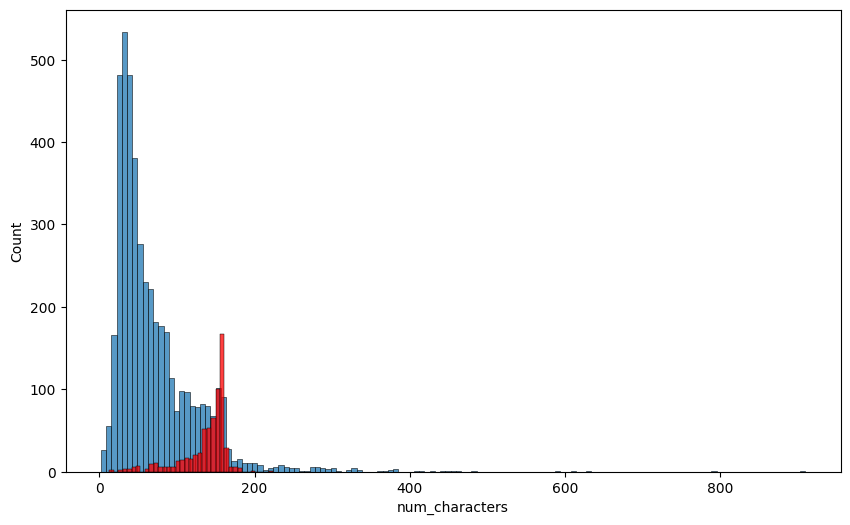

In [16]:
plt.figure(figsize=(10,6))
# Histogram of Characters for HAM
sns.histplot(data[data['target'] == 0]['num_characters'])
# Histogram of Characters for SPAM
sns.histplot(data[data['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

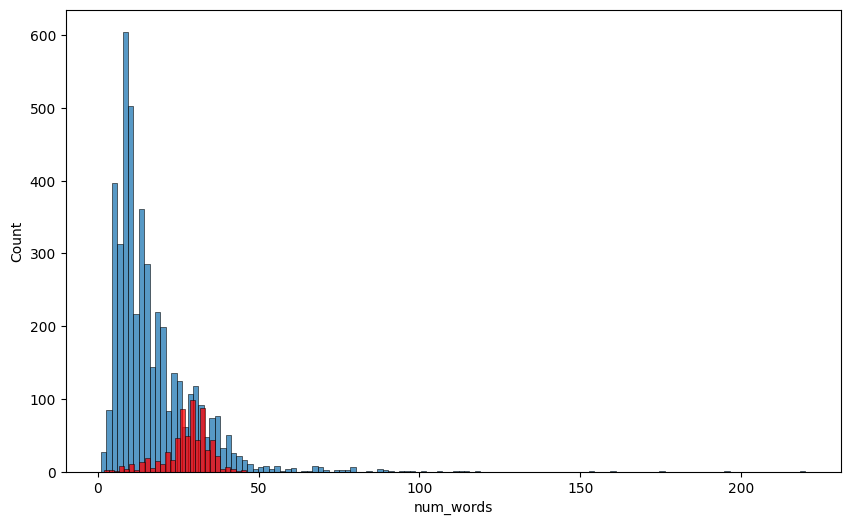

In [20]:
plt.figure(figsize=(10,6))
# Histogram of Words for HAM
sns.histplot(data[data['target'] == 0]['num_words'])
# Histogram of Words for SPAM
sns.histplot(data[data['target'] == 1]['num_words'], color='red')

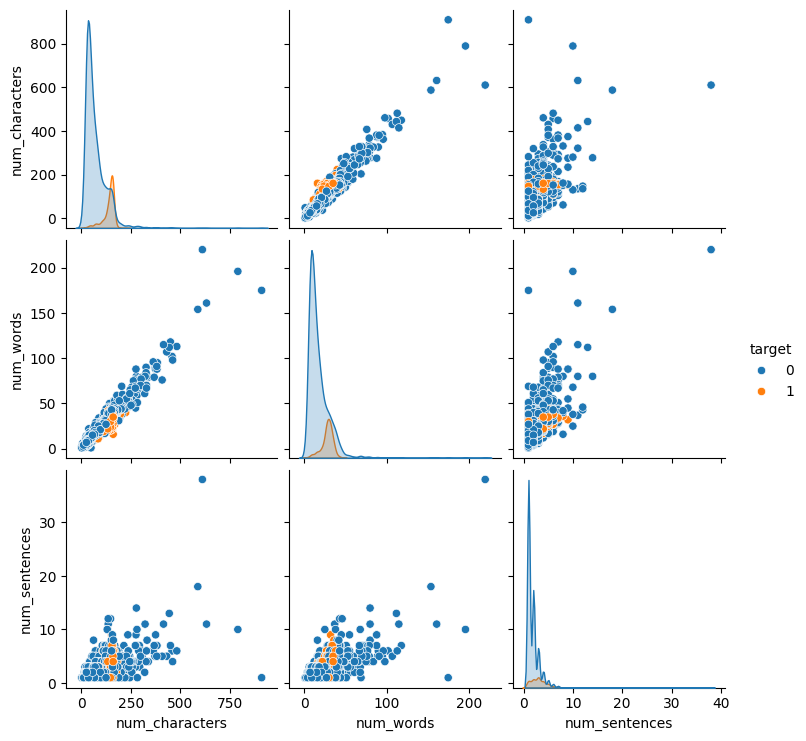

In [21]:
# Checking for outliers:
sns.pairplot(data, hue="target")

<Axes: >

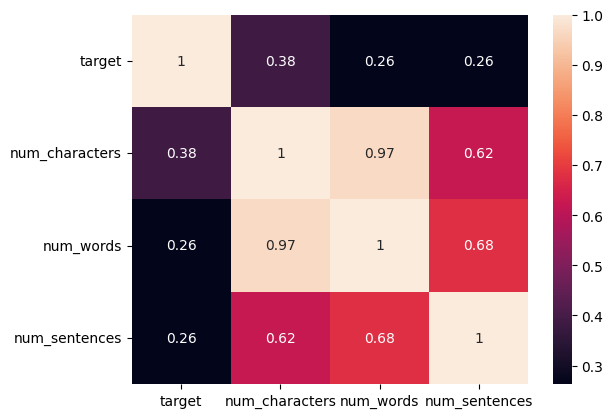

In [18]:
# Checking correlations:
numeric_data = data[['target','num_characters','num_words','num_sentences']]
sns.heatmap(numeric_data.corr(), annot=True)

In [19]:
# It turns out that the 3 columns have a very strong correlation with one another.
# Therefore lets go with num_characters since it has a high correlation with target amongst other 2.
numeric_data.corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.384717,0.262912,0.263939
num_characters,0.384717,1.000000,0.965760,0.624139
num_words,0.262912,0.965760,1.000000,0.679971
num_sentences,0.263939,0.624139,0.679971,1.000000


### Text Preprocessing:

In [20]:
# Function to preprocess the text:
# We make the text lower, tokenize it to words, remove stop words,
# punctuations, special characters and stem it.
def transform_text(text):
    text = text.lower()
    words = nltk.word_tokenize(text)

    ps = PorterStemmer()
    cleaned_words = []

    for word in words:
        if word.isalnum() and word not in stopwords.words('english'):
            cleaned_words.append(ps.stem(word))
    return " ".join(cleaned_words)

In [21]:
data['transformed_text'] = data['text'].apply(transform_text)

In [22]:
data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


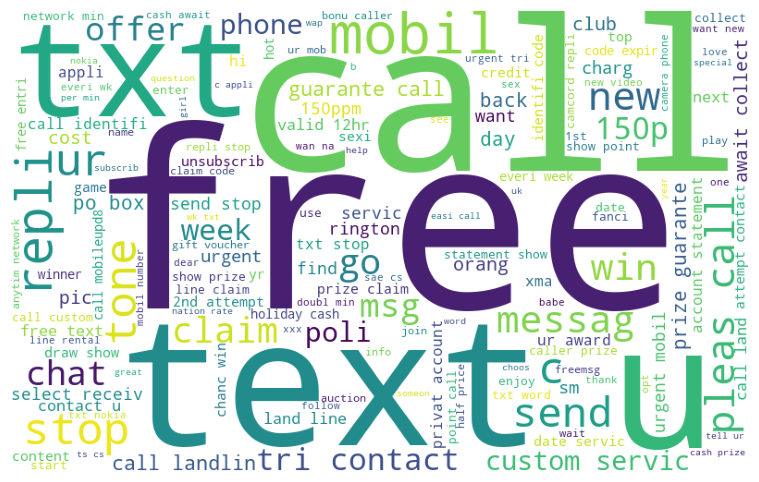

In [21]:
# Generating a Spam Word cloud:
wc = WordCloud(width=800, height=500, min_font_size=10, background_color='white')

spam_wc = wc.generate(data[data['target'] == 1]['transformed_text'].str.cat(sep=' ')) # We convert the list to string.

plt.figure(figsize=(12,6))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()

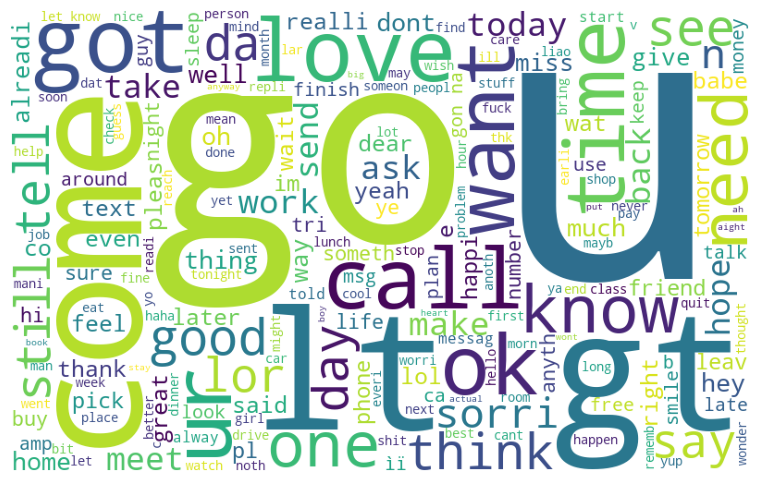

In [22]:
# Generating a Ham Word cloud:
ham_wc = wc.generate(data[data['target'] == 0]['transformed_text'].str.cat(sep=' ')) # We convert the list to string.

plt.figure(figsize=(12,6))
plt.imshow(ham_wc)
plt.axis("off")
plt.show()

### Model building:

In [159]:
# SPLIT DATA FIRST
X = data['transformed_text'].copy()
y = data['target'].values

# Split into train and test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [169]:
# Building a Stacking Classifier:

# BASE MODELS
mnb = MultinomialNB(alpha=0.01)
svc = LinearSVC(random_state=42,
    class_weight='balanced', 
    max_iter=2000)
sgd = SGDClassifier(loss="modified_huber", max_iter=2000, class_weight='balanced')
rfc = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 1,
                             max_features = 'sqrt', max_depth=None, class_weight ='balanced')

# STACKING CLASSIFIER
stack = StackingClassifier(
    estimators=[
        ("mnb", mnb),
        ("svc", svc),
        ("sgd", sgd),
        ('rfc', rfc)
    ],
    final_estimator=LogisticRegression(random_state=42,
        class_weight='balanced',
        C=0.1),
    stack_method="auto"  
)


# FULL PIPELINE
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 1),
        max_features=8000,
        min_df=1,
        norm='l2',
        sublinear_tf=True
    )),
    ("stack", stack)
])


param_dist = {

    # === TF-IDF parameters ===
    "tfidf__max_features": [3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [1, 2, 3],

    # === MultinomialNB ===
    "stack__mnb__alpha": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0],

    # === LinearSVC ===
    "stack__svc__C": [0.1, 0.5, 1, 2],
    "stack__svc__max_iter": [2000, 3000],

    # === SGDClassifier ===
    "stack__sgd__alpha": [1e-5, 1e-4, 1e-3],
    "stack__sgd__loss": ["hinge", "modified_huber"],

    # === RandomForest ===
    "stack__rfc__n_estimators": [50, 100, 200, 300],
    "stack__rfc__max_depth": [None, 10, 20, 30, 50, 70],
    "stack__rfc__min_samples_split": [2, 5, 10],
    "stack__rfc__min_samples_leaf": [1, 2, 4],
    'stack__rfc__max_features': ['sqrt', 'log2'],

    # === Final Estimator (Logistic Regression) ===
    "stack__final_estimator__C": [0.01, 0.1, 1, 5],
    "stack__final_estimator__class_weight": ["balanced", None]
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,            
    cv=5,
    scoring="recall",                
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_raw, y_train)

print("Best Params:", search.best_params_)

best_model = search.best_estimator_
pred = best_model.predict(X_test_raw)

print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1 Score:", f1_score(y_test, pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 3, 'tfidf__max_features': 4000, 'stack__svc__max_iter': 3000, 'stack__svc__C': 2, 'stack__sgd__loss': 'hinge', 'stack__sgd__alpha': 0.001, 'stack__rfc__n_estimators': 50, 'stack__rfc__min_samples_split': 5, 'stack__rfc__min_samples_leaf': 2, 'stack__rfc__max_features': 'sqrt', 'stack__rfc__max_depth': None, 'stack__mnb__alpha': 0.01, 'stack__final_estimator__class_weight': 'balanced', 'stack__final_estimator__C': 0.1}
Accuracy: 0.9748549323017408
Precision: 0.8776978417266187
Recall: 0.9312977099236641
F1 Score: 0.9037037037037037


In [161]:
import pickle

with open("../data/spam_classifier.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved successfully!")

Model saved successfully!


In [164]:
# Testing
with open("../data/spam_classifier.pkl", "rb") as f:
    model = pickle.load(f)

text = ["hey bro!"]
prediction = model.predict(text)
print("Spam" if prediction[0]==1 else "Not Spam")

Not Spam


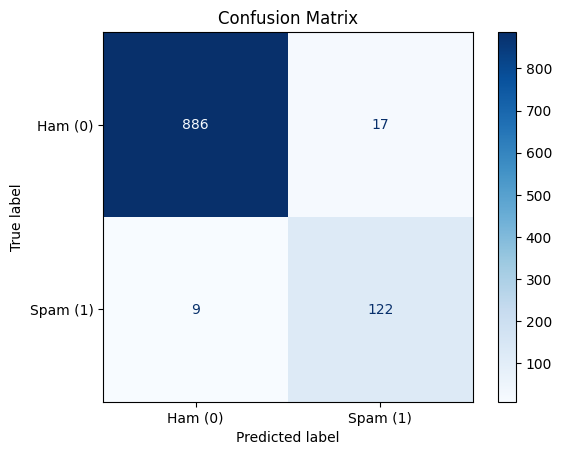

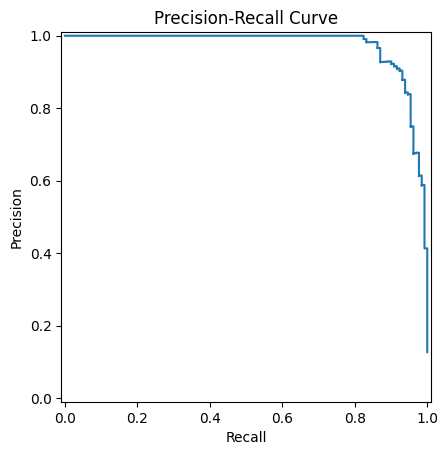

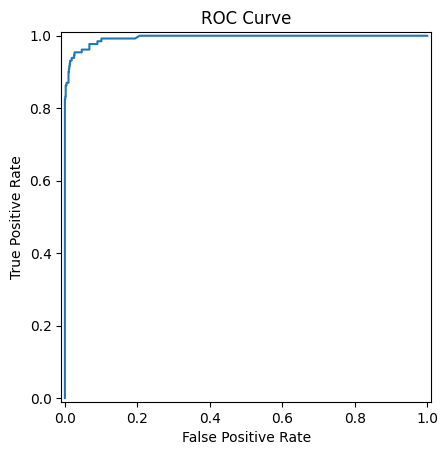

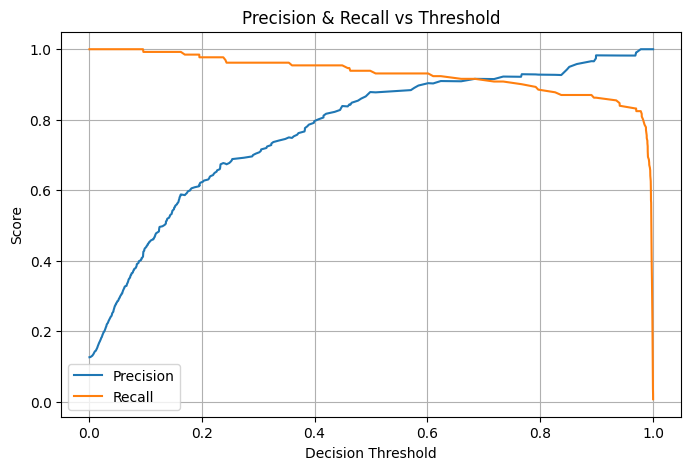

In [170]:
# === Confusion Matrix ===
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham (0)', 'Spam (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# === Precision-Recall Curve ===
# For PR curve, we need probabilities
if hasattr(best_model, "predict_proba"):
    probs = best_model.predict_proba(X_test_raw)[:, 1]
elif hasattr(best_model, "decision_function"):
    probs = best_model.decision_function(X_test_raw)
else:
    raise ValueError("Model has no predict_proba or decision_function method for PR curve")

precision, recall, thresholds = precision_recall_curve(y_test, probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# === ROC Curve ===
fpr, tpr, roc_thresh = roc_curve(y_test, probs)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
disp.plot()
plt.title("ROC Curve")
plt.show()

# === Threshold vs Precision and Recall ===
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

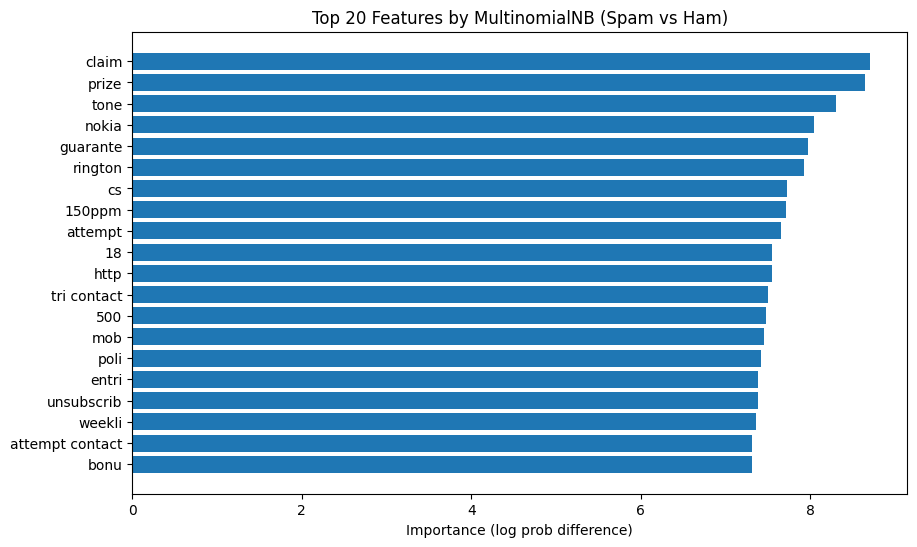

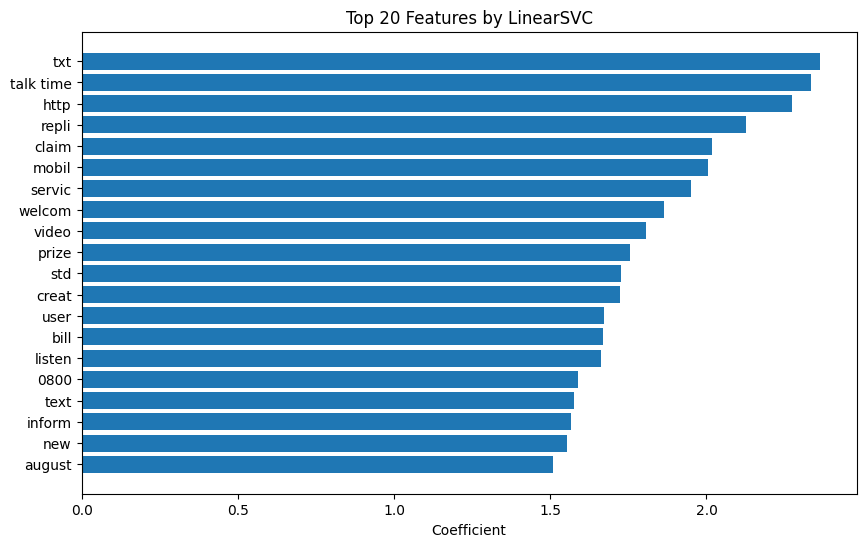

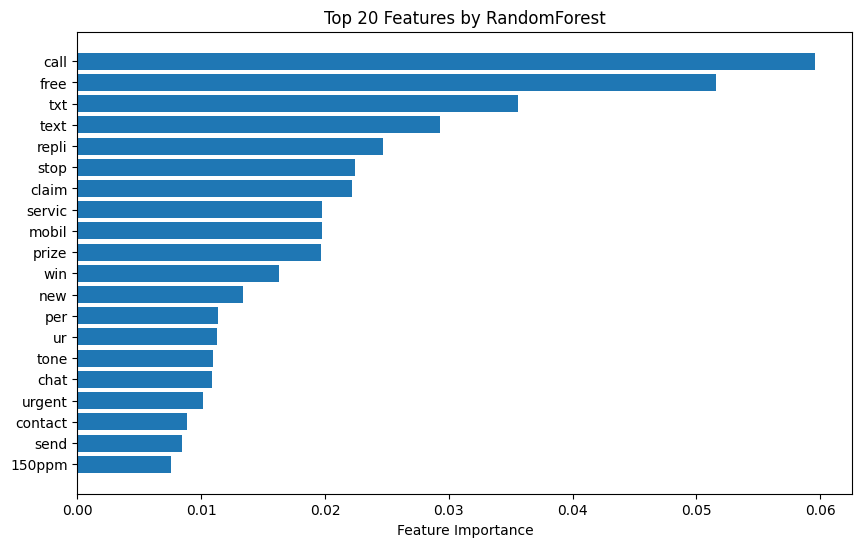

In [171]:
# Get TF-IDF feature names
tfidf = best_model.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

# ===  MultinomialNB feature importance (log probabilities) ===
mnb = best_model.named_steps['stack'].named_estimators_['mnb']
mnb_importance = mnb.feature_log_prob_[1] - mnb.feature_log_prob_[0]  # spam vs ham
mnb_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mnb_importance
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(mnb_df['feature'][::-1], mnb_df['importance'][::-1])
plt.title("Top 20 Features by MultinomialNB (Spam vs Ham)")
plt.xlabel("Importance (log prob difference)")
plt.show()

# === LinearSVC  ===
svc = best_model.named_steps['stack'].named_estimators_['svc']
if hasattr(svc, "coef_"):
    coef = svc.coef_[0]
    svc_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coef
    }).sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10,6))
    plt.barh(svc_df['feature'][::-1], svc_df['importance'][::-1])
    plt.title("Top 20 Features by LinearSVC")
    plt.xlabel("Coefficient")
    plt.show()

# === RandomForest feature importance ===
rfc = best_model.named_steps['stack'].named_estimators_['rfc']
rfc_importance = rfc.feature_importances_
rfc_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rfc_importance
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(rfc_df['feature'][::-1], rfc_df['importance'][::-1])
plt.title("Top 20 Features by RandomForest")
plt.xlabel("Feature Importance")
plt.show()
